### MLS Data Visualization

Last modified: 10/10/2023

In [3]:
# Standard libraries
import warnings
warnings.filterwarnings("ignore", module = "seaborn")

# 3rd party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# Local imports
from mls_stats import Team, league_stats

In [4]:
def round_to_next_five(number: int) -> int:
    return (5 * (round(number/5 +1)))

Forward Passing Accuracy Stripplot (STL v. CIN)

In [5]:
stl = Team('STL', 'St. Louis City SC', 17012, '#ec1458', '#001544', '#fed500')
cin = Team('CIN', 'FC Cincinnati', 11504, '#003087', '#fe5000', '#0b1f41')
stl_df = stl.get_stats()
cin_df = cin.get_stats()
joint_stats = pd.concat([stl_df.all, cin_df.all], ignore_index=True)

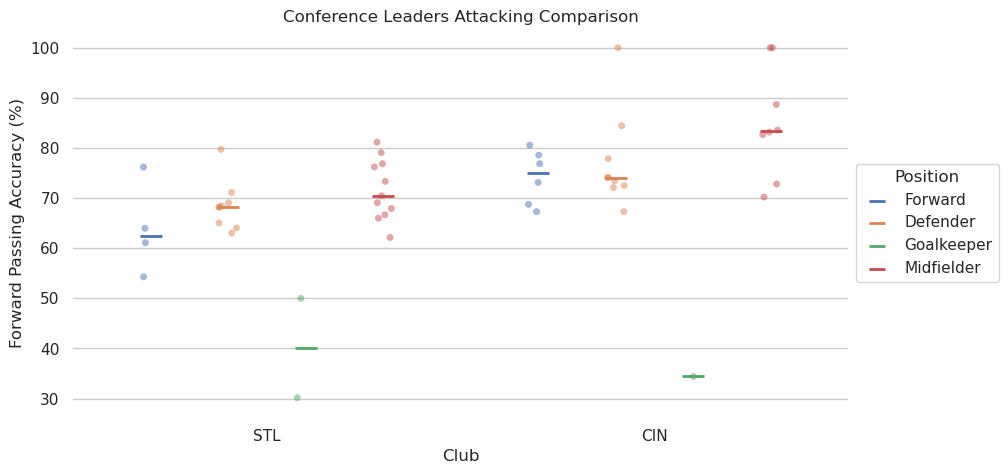

In [6]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(bottom=True, left=True)
sns.stripplot(data=joint_stats, x='club.abbreviation', y='regular_season_statistics.accurate_fwd_zone_pass_per', hue='position_generic', 
              hue_order=['Forward', 'Defender', 'Goalkeeper', 'Midfielder'], alpha=0.50, dodge=True, marker='o', legend=False)
pt_lines = sns.pointplot(data=joint_stats,  x='club.abbreviation', y='regular_season_statistics.accurate_fwd_zone_pass_per', hue='position_generic',
              hue_order=['Forward', 'Defender', 'Goalkeeper', 'Midfielder'], dodge=.6, estimator='median', markers='_', linestyles='none', errorbar=None)

for i in range(8, 12): 
    points = pt_lines.collections[i]
    size= points.get_sizes().item()
    new_sizes=[size*5]
    points.set_sizes(new_sizes)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, title='Position', markerscale=0.75)
ax.set(ylabel='Forward Passing Accuracy (%)', xlabel='Club', title='Conference Leaders Attacking Comparison');

Yellow Cards and Fouls Lost Bivariate Histogram (League)

In [9]:
mls_players = league_stats(2023, 'players')

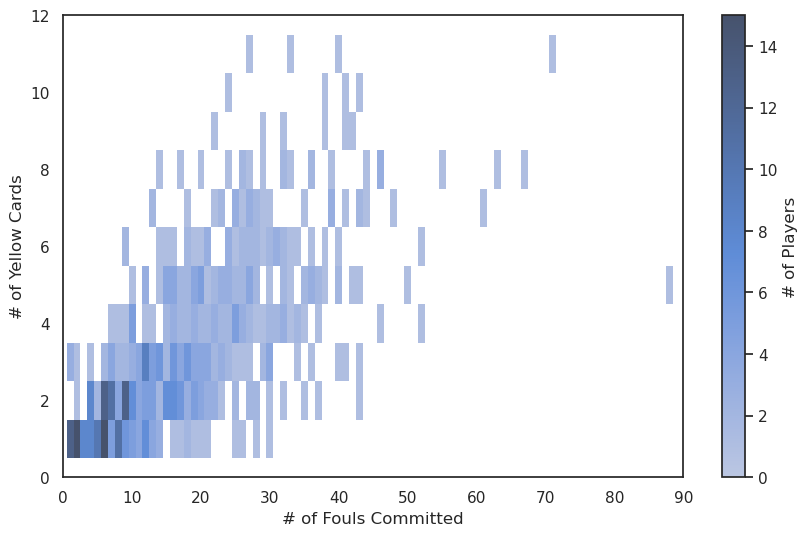

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

sns.set_theme(style='white')
sns.histplot(data=mls_players, x='regular_season_statistics.fk_foul_lost', y='regular_season_statistics.yellow_card', discrete=(True, True),
             cbar=True, cbar_kws={'label': '# of Players'})
ax.set(xlabel='# of Fouls Committed', ylabel='# of Yellow Cards', xlim=(0, 90), ylim=(0, 12));

Goals Pair Grid (League)

/home/gtorrini/portfolio/data/mls_stats.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df['conference'] = conf


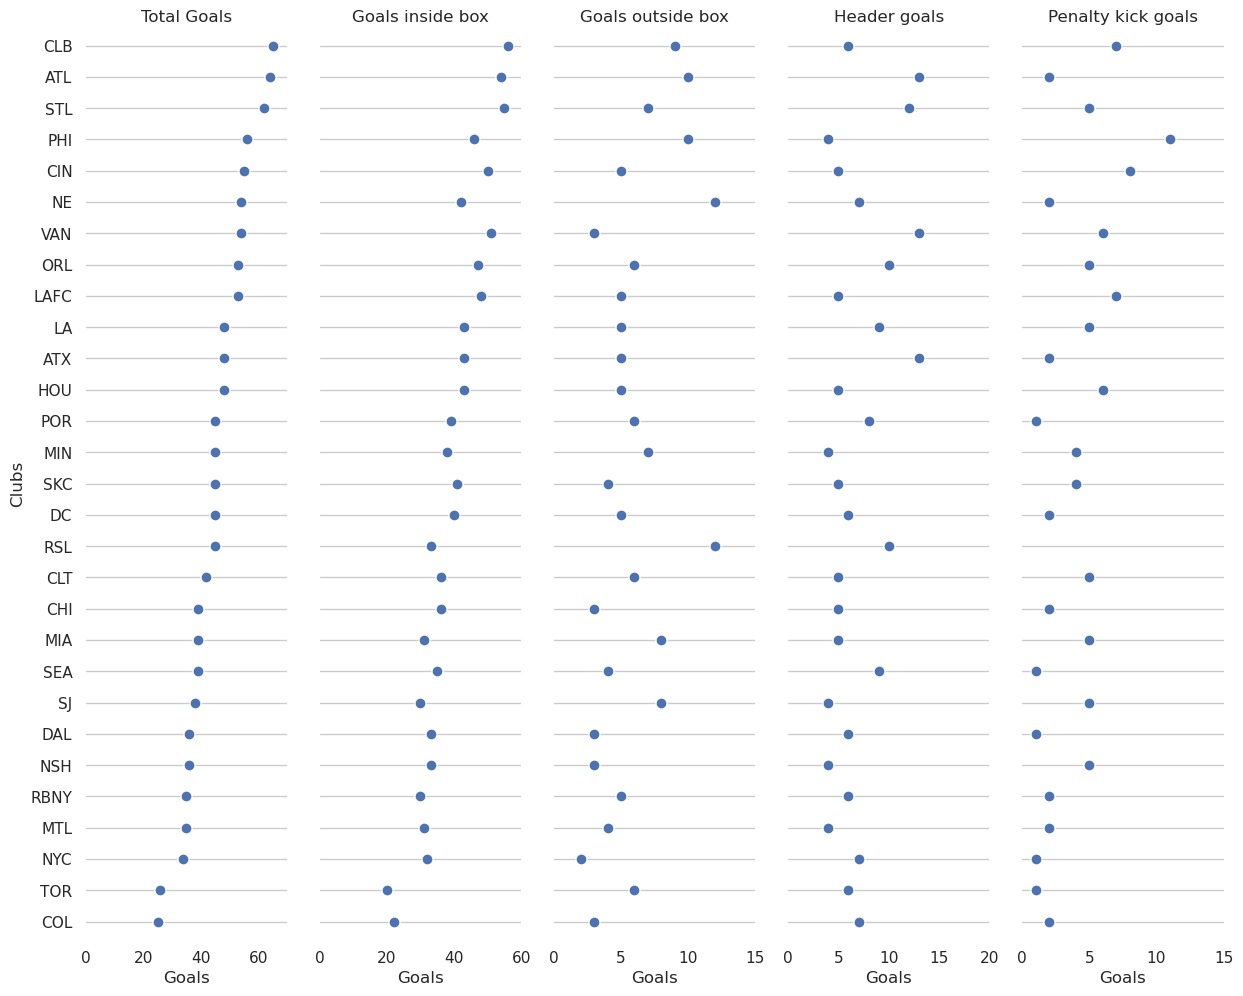

In [12]:
mls_clubs = league_stats(2023, 'clubs')

goal_cols = ['regular_season_statistics.goals', 'regular_season_statistics.att_ibox_goal', 'regular_season_statistics.att_obox_goal', 
             'regular_season_statistics.att_hd_goal', 'regular_season_statistics.att_pen_goal']

g = sns.PairGrid(mls_clubs.sort_values(by='regular_season_statistics.goals', ascending=False),
                 x_vars=goal_cols,
                 y_vars=['club.abbreviation'], height=10, aspect=.25)

g.map(sns.stripplot, size=8, orient='h', jitter=False, palette='flare_r', linewidth=1, edgecolor='w')
g.set(xlabel='Goals', ylabel='Clubs')

titles = ["Total Goals", "Goals inside box", "Goals outside box",
          "Header goals", "Penalty kick goals"]

for i, (ax, title) in enumerate(zip(g.axes.flat, titles)):

    # Set a different title for each axes
    ax.set(title=title, xlim=(0, round_to_next_five(mls_clubs[goal_cols[i]].max())))

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

Win-Draw-Loss Record Since 2000 (SKC)

In [13]:
skc = Team('SKC', 'Sporting Kansas City', 421, '#0c2340', '#a5bad6', '#878b8c')
wins = []
draws = []
losses = []

for i in range(2000, 2023):     # draws were only introduced to rules in 2000
    league_df = league_stats(i, 'clubs')
    skc_df = league_df[league_df['club.abbreviation'] == 'SKC']
    wins.append(skc_df['regular_season_statistics.total_wins'].loc[skc_df.index[0]])
    draws.append(skc_df['regular_season_statistics.total_draws'].loc[skc_df.index[0]])
    losses.append(skc_df['regular_season_statistics.total_losses'].loc[skc_df.index[0]])

years = np.array(range(2000, 2023))
wdl_stats = {
    'Wins': np.array(wins),
    'Draws': np.array(draws),
    'Losses': np.array(losses),
}

/home/gtorrini/portfolio/data/mls_stats.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df['conference'] = conf
/home/gtorrini/portfolio/data/mls_stats.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df['conference'] = conf
/home/gtorrini/portfolio/data/mls_stats.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

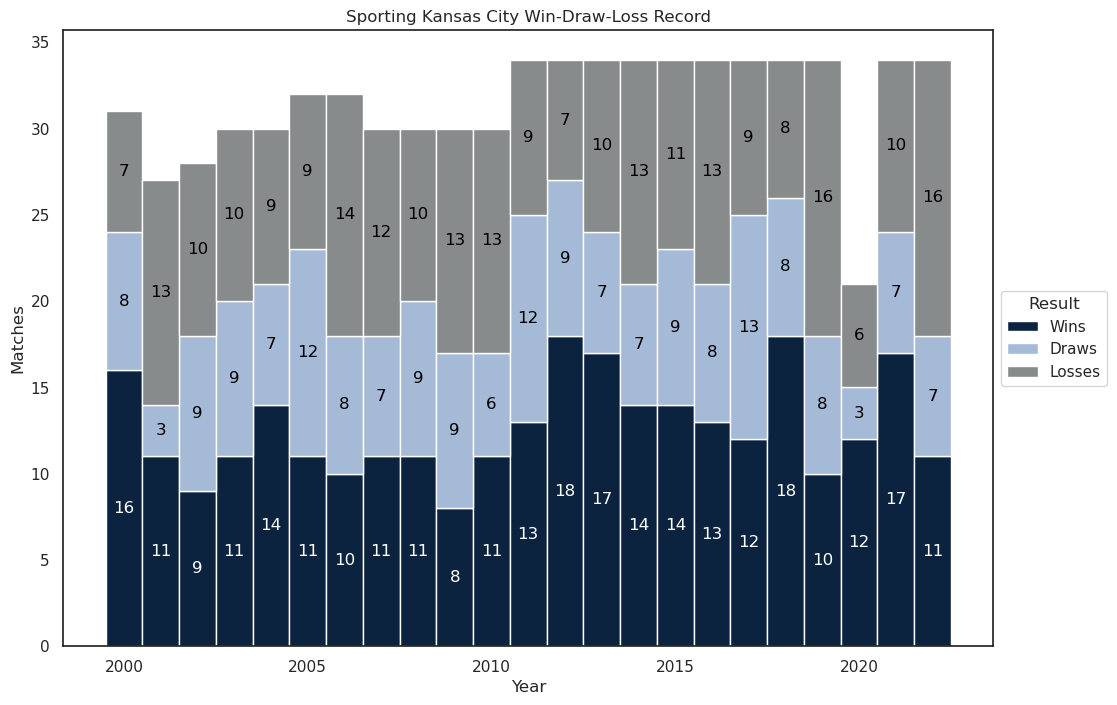

In [ ]:
width = 1
bottom = np.zeros(23)

fig, ax = plt.subplots(figsize=(12, 8))
label_cols = ['white', 'black', 'black']
for i, (result, wdl_stat) in enumerate(wdl_stats.items()):
    col_var = f'''skc.color_{i+1}'''
    p = ax.bar(years, wdl_stat, width, label=result, bottom=bottom, color=eval(col_var))
    bottom += wdl_stat

    ax.bar_label(p, label_type='center', color=label_cols[i])

ax.legend(title='Result', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sporting Kansas City Win-Draw-Loss Record', xlabel='Year', ylabel='Matches');

Which statistics correlate the most with highest win rate and highest goal differential?

Correlation Matrix Heatmap

Linear Regression

In [30]:
res = stats.linregress(mls_clubs['regular_season_statistics.possession_percentage'], mls_clubs['regular_season_statistics.goals'])
res2 = stats.linregress(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], mls_clubs['regular_season_statistics.goals'])

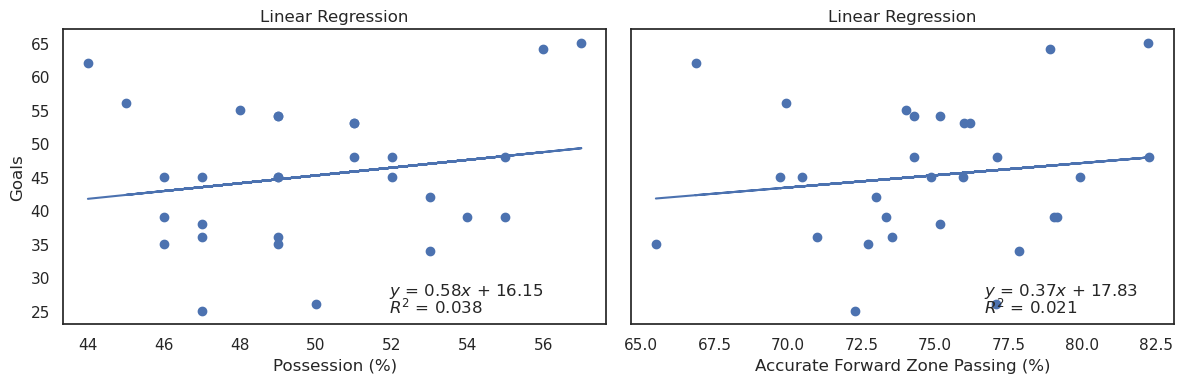

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 4), tight_layout=True)

# First set
axes[0].scatter(mls_clubs['regular_season_statistics.possession_percentage'], mls_clubs['regular_season_statistics.goals'], label='Data')
axes[0].plot(mls_clubs['regular_season_statistics.possession_percentage'], (res.intercept + res.slope * mls_clubs['regular_season_statistics.possession_percentage']), label='Fitted Line')
axes[0].text(0.6, 0.1, f'''$y$ = {round(res.slope, 2)}$x$ + {round(res.intercept, 2)}''', transform=axes[0].transAxes)
axes[0].text(0.6, 0.04, f'''$R^2$ = {round(res.rvalue**2, 3)}''', transform=axes[0].transAxes)
axes[0].set(xlabel='Possession (%)', ylabel='Goals', title='Linear Regression');

# Second set
axes[1].scatter(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], mls_clubs['regular_season_statistics.goals'], label='Data')
axes[1].plot(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], (res2.intercept + res2.slope * mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per']), label='Fitted Line')
axes[1].text(0.65, 0.1, f'''$y$ = {round(res2.slope, 2)}$x$ + {round(res2.intercept, 2)}''', transform=axes[1].transAxes)
axes[1].text(0.65, 0.04, f'''$R^2$ = {round(res2.rvalue**2, 3)}''', transform=axes[1].transAxes)
axes[1].set(xlabel='Accurate Forward Zone Passing (%)', title='Linear Regression');

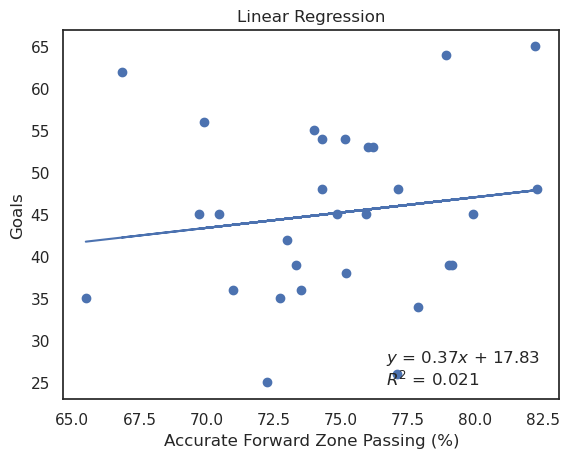

In [29]:
res2 = stats.linregress(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], mls_clubs['regular_season_statistics.goals'])

fig, ax = plt.subplots()
ax.scatter(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], mls_clubs['regular_season_statistics.goals'], label='Data')
ax.plot(mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per'], (res2.intercept + res2.slope * mls_clubs['regular_season_statistics.accurate_fwd_zone_pass_per']), label='Fitted Line')
ax.text(0.65, 0.1, f'''$y$ = {round(res2.slope, 2)}$x$ + {round(res2.intercept, 2)}''', transform=ax.transaxes)
ax.text(0.65, 0.04, f'''$R^2$ = {round(res2.rvalue**2, 3)}''', transform=ax.transaxes)
ax.set(xlabel='Accurate Forward Zone Passing (%)', ylabel='Goals', title='Linear Regression');